# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import shap
#from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
#!pip install phik
import phik
from phik import report
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import time

In [2]:
np.random.seed(0)

## Подготовка данных

In [3]:
try:
    data = pd.read_csv('datasets/autos.csv')
except FileNotFoundError: 
    data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.columns = data.columns.str.lower() # Приводим имена колонок в порядок

In [6]:
data.drop_duplicates(inplace=True) # Удаляем дубликаты

### Обрабатываем пропуски

In [7]:
# Посмотрим на количество пропусков
pd.DataFrame(round(data.isna().mean()*100, 5)).style.background_gradient('coolwarm') 

,0
datecrawled,0.000000
price,0.000000
vehicletype,10.579490
registrationyear,0.000000
gearbox,5.596770
power,0.000000
model,5.560650
kilometer,0.000000
registrationmonth,0.000000
fueltype,9.282800


In [8]:
# создадим фичу разницы в днях между моментом публикации и последним просмотром

data['lastseen'] = pd.to_datetime(data['lastseen']).dt.date.astype('datetime64[ns]')
data['datecreated'] = pd.to_datetime(data['datecreated'])
data['longdate'] = (data['lastseen'] - data['datecreated']).apply(lambda x: str(x).split()[0]).astype('int64')

In [9]:
# Удаляем ненужные столбцы дат и количества фотографий(т.к. там сплошные нули)

data.drop(['datecrawled', 'lastseen', 'datecreated', 'numberofpictures'], axis=1, inplace=True)

In [10]:
# Маркируем пропуски в категориальных переменных категорией "неизвестно"

data.fillna('unknown', inplace=True)

In [11]:
# Отсечем выбросы в столбце power и попробуем предсказать пропуски (нули) 
# в этом столбце при помощи lightGBM

data = data.query('power <400')

power_cols = [col for col in data.columns if data[col].dtype=='int64' and col !='price']
data['power'] = data['power'].replace({0 : 'NaN'}).astype('float')

data_power = data[power_cols]
data_power['power'] = data['power']
train_power = data_power.loc[data_power['power'].isnull() == False]
test_power = data_power.loc[data_power['power'].isnull() == True]

y_train_power = train_power['power']
X_train_power = train_power.drop('power', axis=1)
X_test_power = test_power.drop('power', axis=1)


repaired_clf = LGBMRegressor()
repaired_clf.fit(X_train_power, y_train_power)

data['power'].fillna(pd.Series(repaired_clf.predict(X_test_power), index = X_test_power.index), inplace=True)
data['power'] = data['power'].astype('int64')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
pd.DataFrame(round(data.isna().mean()*100, 5)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicletype,0.000000
registrationyear,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
registrationmonth,0.000000
fueltype,0.000000
brand,0.000000


### Отсекаем выбросы

In [13]:
# отсечем совсем старые автомобили, а также ошибки в годе регистрации
data = data.query('1990 < registrationyear < 2016')
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='registrationyear', ylabel='Count'>

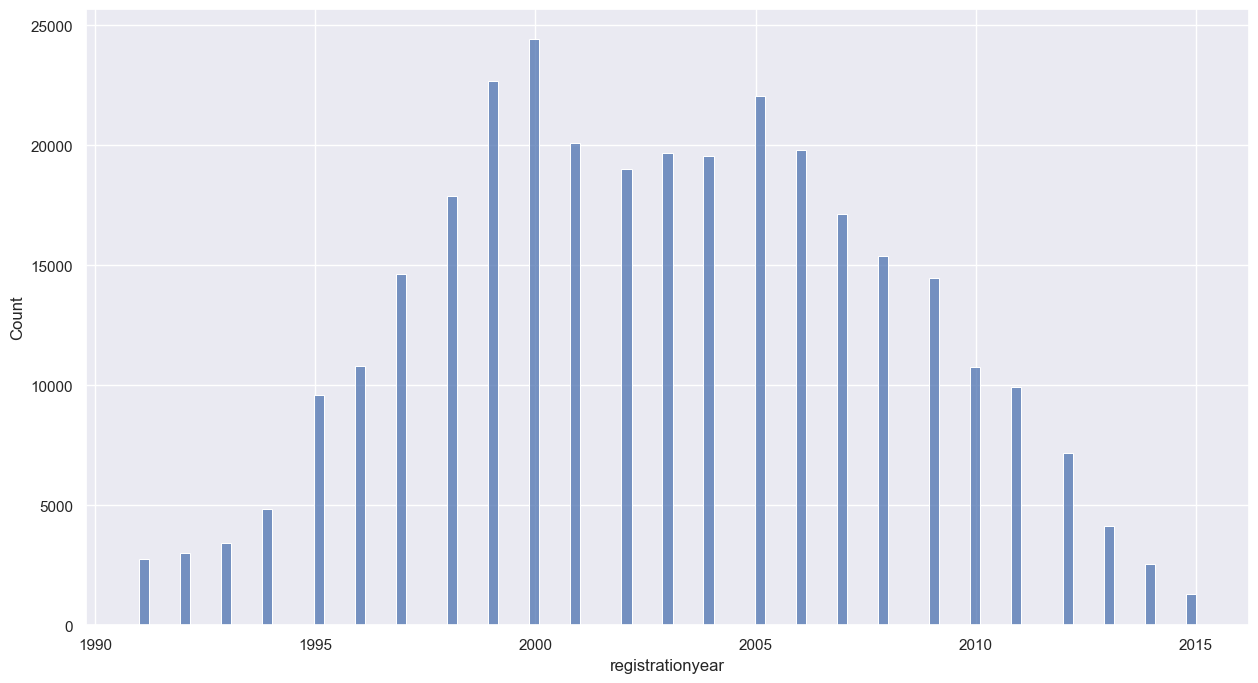

In [14]:
sns.histplot(data.registrationyear)

<AxesSubplot:xlabel='power', ylabel='Count'>

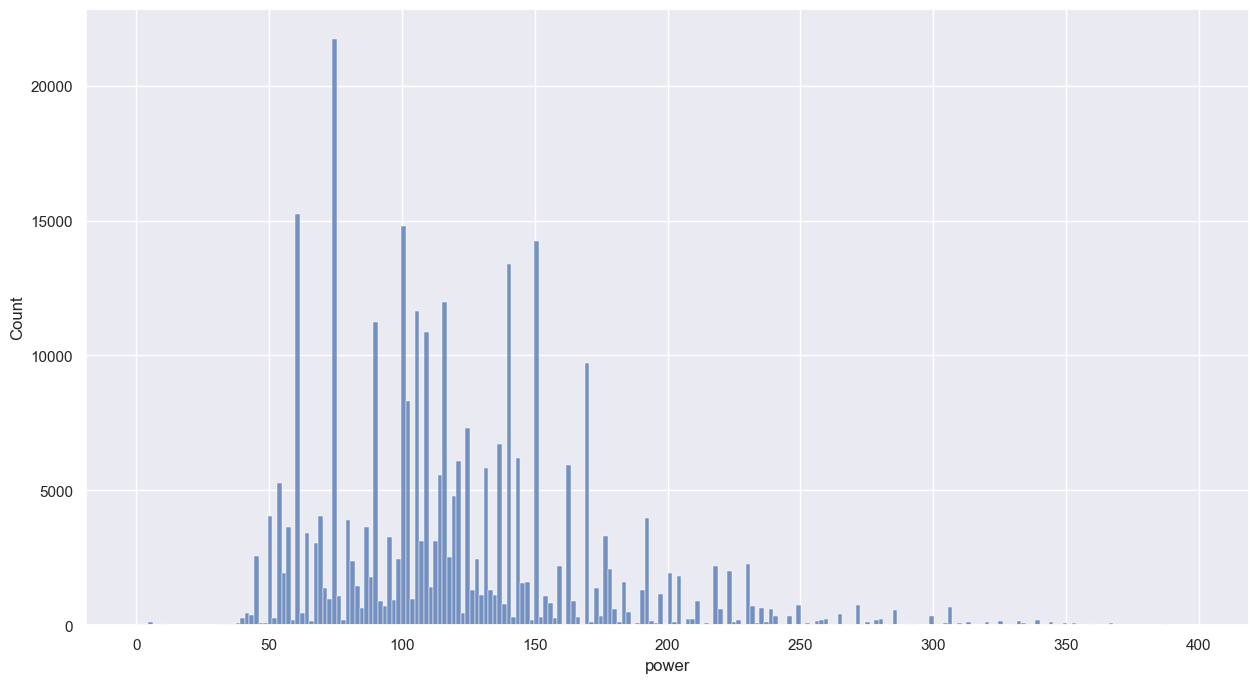

In [15]:
sns.histplot(data.power) # мощность отсечена выше.

In [16]:
data['registrationmonth'].value_counts() #пожалуй, не будем обрабатывать 

3     31382
6     28588
0     27908
4     26514
5     26484
7     24507
10    23992
12    22322
11    22257
9     21896
1     21041
8     20676
2     19501
Name: registrationmonth, dtype: int64

In [17]:
# Для разбиения выборки и правильной работы OHE отсечем модели с 1 экземпляром.
model_values = data['model'].value_counts()[data['model'].value_counts() > 3].index

data = data.query('model in @model_values')

In [18]:
data = data.query('longdate < 35') # отсечем выбросы в новой фиче

<AxesSubplot:xlabel='longdate', ylabel='Count'>

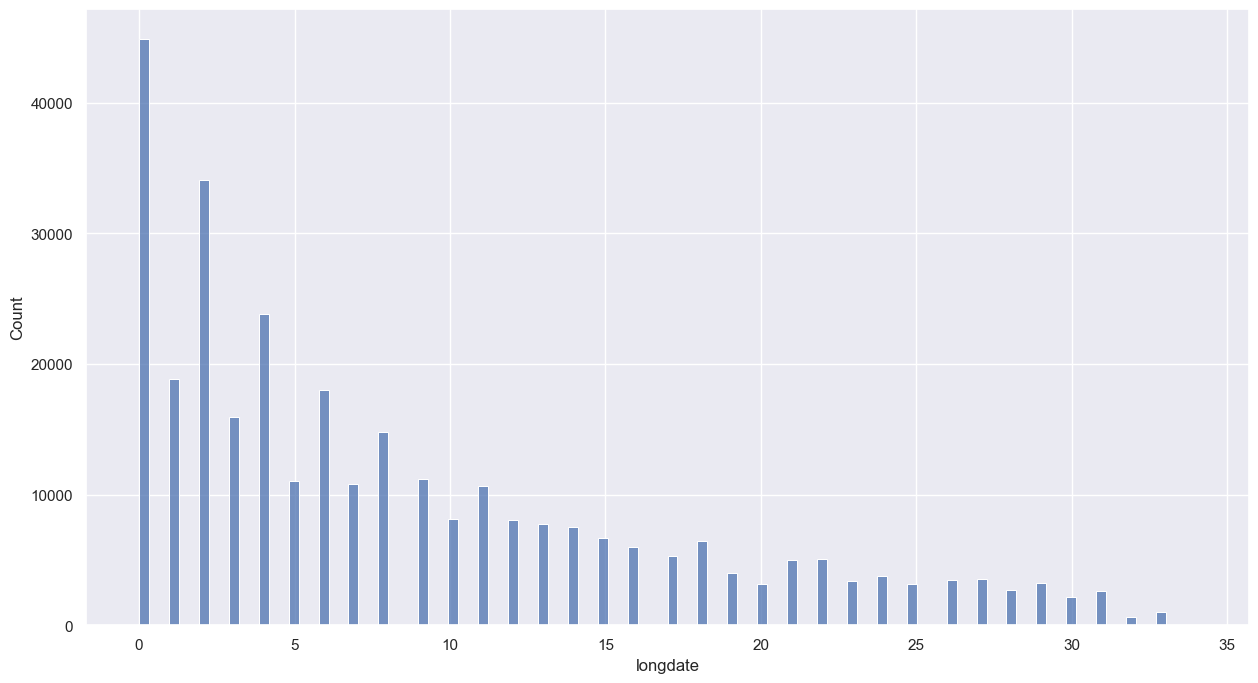

In [19]:
sns.histplot(data['longdate'])

In [20]:
cat_features = [col for col in data.columns if data[col].dtype == 'object']
num_features = [col for col in data.columns if (data[col].dtype != 'object') & (col != 'price')]

In [21]:
data = data.query('price > 0')

<AxesSubplot:xlabel='price', ylabel='Count'>

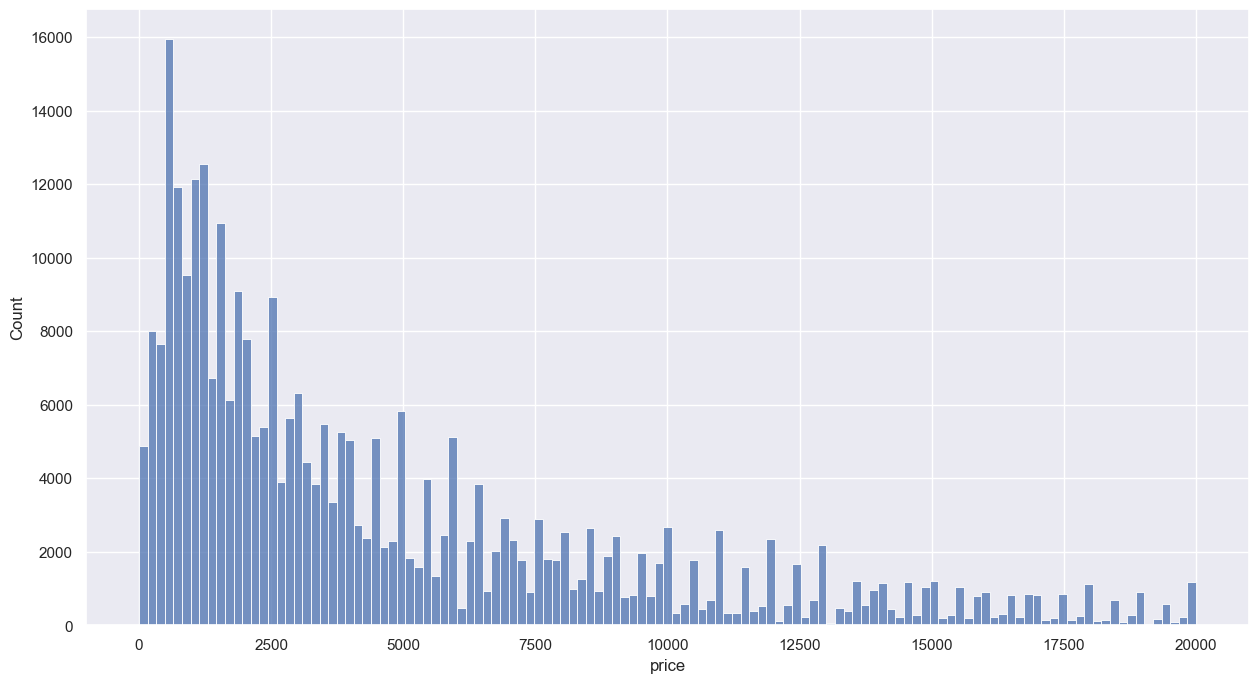

In [22]:
sns.histplot(data.price)

### Посмотрим на корреляцию численных и категориальных фичей

<AxesSubplot:>

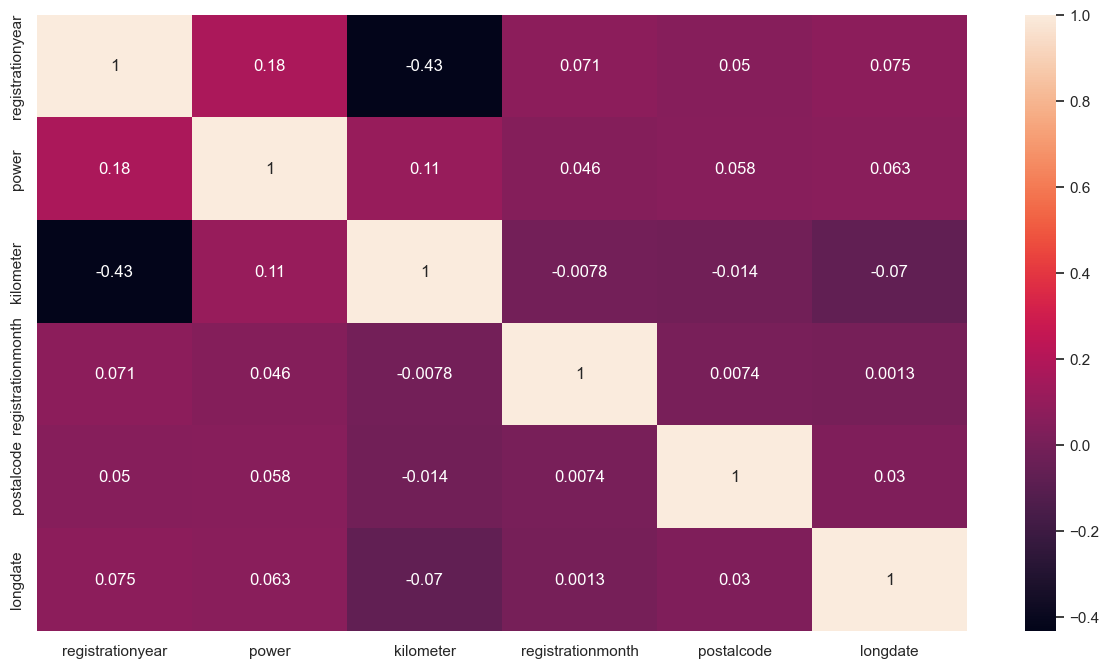

In [23]:
corr = data[num_features].corr()
sns.heatmap(corr, annot=True)

<AxesSubplot:>

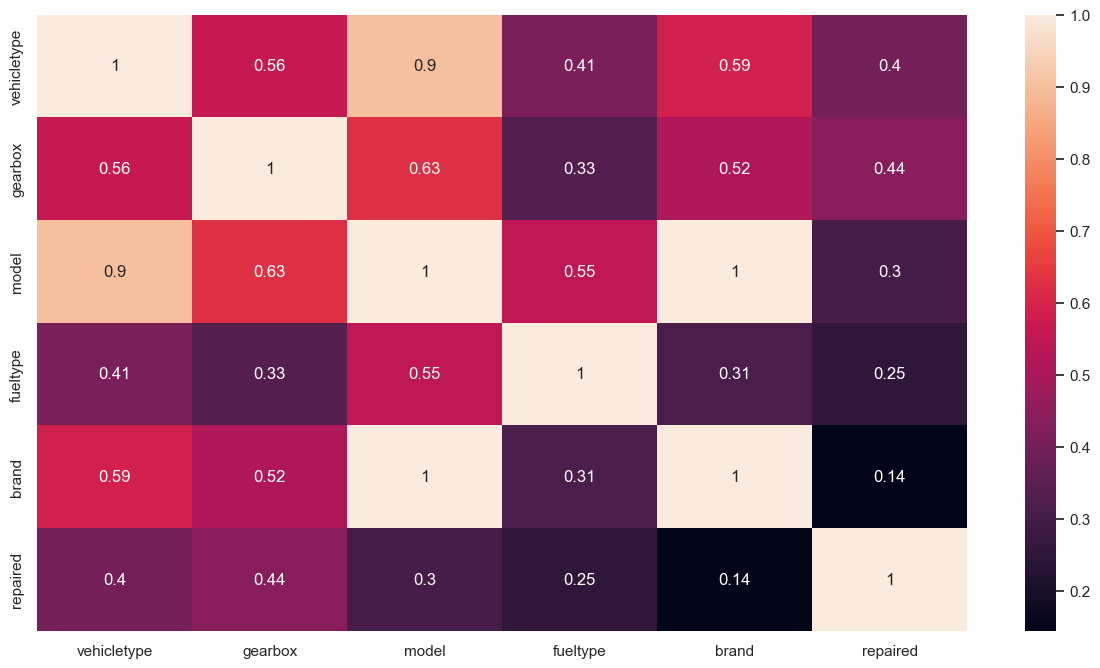

In [24]:
sns.heatmap(data[cat_features].phik_matrix(), annot=True)

### Делим выборку

In [25]:
X = data.drop('price', axis=1)
y = data['price']

In [26]:
X['noise'] = np.random.rand(X.shape[0]) # Добавляем колонку шума, чтобы установить порог на важность фичей

In [27]:
X[cat_features] = X[cat_features].astype('category')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['model'])

## Обучение моделей

1. Подбор параметров будем вести при помощи HyperOpt
2. Рассмотрим 3 модели: 
   * CatBooost
   * LightGBM
   * LinearRegression
   
* Примечание: пространство выбора параметров,число разбиений для кросс-валидации, а также число итераций подбора было снижено в угоду скорости работы.


In [29]:
def rmse(y, y_pred):
    return (mean_squared_error(y_pred, y))**0.5

In [30]:
RMSE = make_scorer(rmse, greater_is_better=False)

In [31]:
class OptHyperparams():
    def __init__ (self, algorithm, X, y):
        trials = Trials()
        self.algo = algorithm
        self.X = X
        self.y = y
        print(f'Создан')
        
    def __cross_val(self, params):
      
        cross_val = cross_val_score(self.algo(**params, **self.others_params), 
                        X=self.X, 
                        y=self.y, 
                        scoring=RMSE,
                        cv=KFold(n_splits=self.splits, shuffle=True),
                        #error_score='raise'
                       )

        result = {'loss': -cross_val.mean(), 'status': STATUS_OK}
        print(f'средний RMSE: {-cross_val.mean():.4f}    RMSE: {-cross_val}')
        return result
    
    def best_params(self, space, others_params, splits, max_evals):
        
        self.others_params = others_params
        self.splits = splits
        
        best_params = fmin(self.__cross_val, space = space, algo=tpe.suggest, trials= Trials(), max_evals=max_evals)
        print ('Лучшие гиперпараметры:', best_params)
        return best_params

### Catboost

In [32]:
space_catboost = {
    'n_estimators' : scope.int(hp.quniform('n_estimators', 50, 500, 100)), 
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 8, 2)),
}
others_params_catboost = {
    'silent':True,
    'learning_rate': 0.5, 
    'cat_features' : cat_features
                }

In [33]:
opthyperparams_catboost = OptHyperparams(CatBoostRegressor, X_train, y_train)

Создан


In [34]:
best_params_cbr = opthyperparams_catboost.best_params(space_catboost, others_params_catboost, 3, 5)

средний RMSE: 1547.8659    RMSE: [1563.65182037 1543.81454799 1536.13145721]
средний RMSE: 1527.0579    RMSE: [1527.74693104 1533.37540398 1520.05124526]  
средний RMSE: 1507.9404    RMSE: [1506.42783752 1514.30714446 1503.08607399]   
средний RMSE: 1544.4453    RMSE: [1543.1300586  1545.26010266 1544.94580654]   
средний RMSE: 1504.7291    RMSE: [1495.80882524 1510.29035047 1508.08809107]   
100%|██████████| 5/5 [02:52<00:00, 34.42s/trial, best loss: 1504.7290889267833]
Лучшие гиперпараметры: {'max_depth': 6.0, 'n_estimators': 200.0}


### LightGBM

In [35]:
space_lgbmr = {
    'n_estimators' : scope.int(hp.quniform('n_estimators', 50, 500, 100)), 
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 8, 2)),
}
others_params_lgbmr = {
    'learning_rate': 0.5
                }

In [36]:
opthyperparams_lgbmr = OptHyperparams(LGBMRegressor, X_train, y_train)

Создан


In [37]:
best_params_lgbmr = opthyperparams_lgbmr.best_params(space_lgbmr, others_params_lgbmr, 3, 5)

средний RMSE: 1518.3257    RMSE: [1526.89465452 1514.91151453 1513.17090189]
средний RMSE: 1494.0408    RMSE: [1495.74832263 1496.09495787 1490.27900626]   
средний RMSE: 1525.3078    RMSE: [1542.01372096 1508.31054826 1525.59898722]   
средний RMSE: 1519.9830    RMSE: [1513.50795416 1518.7462819  1527.69467081]   
средний RMSE: 1508.7243    RMSE: [1505.15626394 1517.15421124 1503.86235307]   
100%|██████████| 5/5 [00:17<00:00,  3.49s/trial, best loss: 1494.0407622526754]
Лучшие гиперпараметры: {'max_depth': 4.0, 'n_estimators': 400.0}


### Линейная регрессия

In [38]:
cat_pipeline = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])
num_pipeline = Pipeline([('scaler', StandardScaler())])
preprocessor = ColumnTransformer([('cat', cat_pipeline, cat_features),
                                 ('num', num_pipeline, num_features)])
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('line_reg', LinearRegression())])

In [39]:
%%time
start = time.time()

pipeline.fit(X_train, y_train)

end = time.time()

lr_time_fit = round(end-start, 2)

Wall time: 4.87 s


In [40]:
%%time
start = time.time()


preprocessor.fit_transform(X_test)

start = time.time()

lr_pred = pipeline.predict(X_test)

end = time.time()
lr_time_predict = round(end-start, 2)

Wall time: 508 ms


In [41]:
best_rmse_lr = rmse(lr_pred , y_test)
best_rmse_lr 

2203.3934340448204

## Анализ моделей

#### Catboost

In [42]:
best_model_cbr = CatBoostRegressor(**best_params_cbr)

In [43]:
%%time
start = time.time()


best_model_cbr.fit(X_train, y_train, 
               cat_features=cat_features, 
               silent = True,  
               #plot=True, 
               #eval_set=(X_test, y_test)
                  )
end = time.time()

catboost_time_fit = round(end-start, 2)              

Wall time: 19.1 s


In [44]:
%%time
start = time.time()

cbr_pred = best_model_cbr.predict(X_test)

end = time.time()
catboost_time_predict = round(end-start, 2)    

Wall time: 73.6 ms


In [45]:
best_rmse_catboost  = rmse(cbr_pred, y_test)
best_rmse_catboost

1488.7699707705729

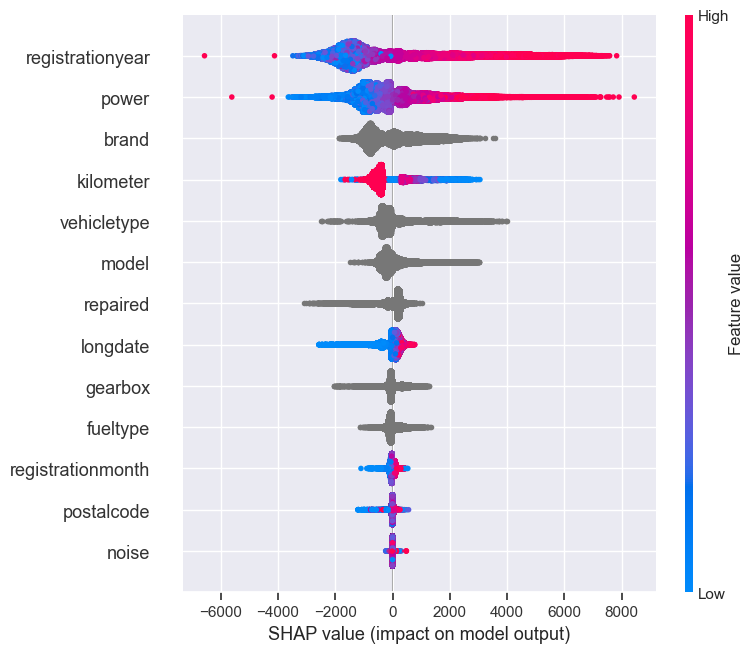

In [46]:
shap_values = shap.TreeExplainer(best_model_cbr).shap_values(X_test)
shap.summary_plot(shap_values , X_test, max_display=15)

In [47]:
pd.DataFrame(best_model_cbr.feature_importances_, best_model_cbr.feature_names_, columns = ['Важность']).sort_values(by='Важность', ascending=False).style.bar()

,Важность
registrationyear,39.212967
power,26.364066
brand,9.714318
vehicletype,6.636701
kilometer,5.807723
model,4.294675
repaired,2.848297
longdate,2.043647
fueltype,1.405606
gearbox,0.909996


#### LightGBM

In [48]:
best_params_lgbmr = {k: int(v) for k, v in best_params_lgbmr.items()}

In [49]:
best_model_lgbmr = LGBMRegressor(**best_params_lgbmr)

In [50]:
%%time
start = time.time()
best_model_lgbmr.fit(X_train, y_train, 
                     #eval_set=(X_test, y_test),
                     eval_metric='RMSE',
                     verbose=10)

end = time.time()

lgbm_time_fit = round(end-start, 2)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Wall time: 1.86 s


In [51]:
%%time
start = time.time()

lgbm_pred = best_model_lgbmr.predict(X_test)

end = time.time()
lgbm_time_predict = round(end-start, 2)

Wall time: 491 ms


In [52]:
best_rmse_lightgbm = rmse(lgbm_pred, y_test)
best_rmse_lightgbm

1473.5144715208612

In [54]:
result = pd.DataFrame(
    [
        [
        catboost_time_fit,
        catboost_time_predict,
        best_rmse_catboost
    ],
    
    [
        lgbm_time_fit,
        lgbm_time_predict,
        best_rmse_lightgbm
    ],
    
    [
        lr_time_fit,
        lr_time_predict,
        best_rmse_lr
    ]
    ],
    
    columns = [
        'Время обучения', 
        'Время предсказания' , 
        'Лучший RMSE на тесте'
    ],
    index = [
        'CatBoost',
        'LightGBM',
        'LinearRegression'
    ]
)

result 

,Время обучения,Время предсказания,Лучший RMSE на тесте
CatBoost,19.07,0.07,1488.769971
LightGBM,1.86,0.49,1473.514472
LinearRegression,4.87,0.27,2203.393434


# Выводы:
1. Лучшее значение метрики, а также время предсказания, получено на CatBoost, но время обучения сильно хуже остальных моделей.
2. По соотношению времен обучения и предсказания, а также целевой метрики, лучшей (скорее более универсальной) моделью является LightGBM .